# 데이터 처리
## investing.com
### JOIN 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

In [ ]:
data_df = pd.read_excel('palm_nino_concat.xlsx')

In [ ]:
data_df.head()

### 데이터 선택
2008년 이전 데이터는 불연속적이므로 2008년 이후만 사용한다.

In [ ]:
df = data_df.query('YEAR > 2007')

In [ ]:
df

### 인덱스, 열 처리

In [ ]:
df.set_index('DATE', inplace = True)

In [ ]:
df.drop(columns = ['YEAR', 'MONTH', 'year', 'month'], inplace = True)

In [ ]:
df.head()

## FIS

### FIS 팜유-nino3.4 JOIN 데이터 만들기

In [16]:
palm_df = pd.read_excel('PALMOIL_FUTURE-FIS.xlsx')
nino34_df = pd.read_excel('nino34.xlsx', sheet_name = 'Nino3.4')

In [17]:
nino34_df = pd.melt(nino34_df, id_vars=['year'], value_vars=list(nino34_df.columns.values)[1:], var_name='month', value_name='nino34')

In [ ]:
nino34_df.head()

In [19]:
nino34_df['DATE'] = pd.to_datetime(nino34_df[['year', 'month']].assign(DAY=1))
nino34_df.sort_values(by='DATE', inplace=True)

In [ ]:
nino34_df.head()

In [21]:
palm_df.rename(columns = {'기간(월)': 'DATE'}, inplace = True)

In [ ]:
palm_df.head()

In [ ]:
print(len(nino34_df))
print(len(palm_df))

In [24]:
df = palm_df.merge(nino34_df, how = 'inner', on = 'DATE')

In [ ]:
len(df)

In [ ]:
df.sort_values(by = 'DATE', inplace = True)
df

### 인덱스, 열 처리

In [27]:
df.set_index('DATE', inplace = True)
df.drop(columns = ['전년동월평균가', '전년도동월대비', 'year', 'month', '평균가', '등락률(%)', '환산가($/ton)'], inplace = True)

In [ ]:
df.tail()

In [29]:
df.to_excel('FIS_nino.xlsx')

In [2]:
df = pd.read_excel('FIS_nino.xlsx')

In [18]:
import matplotlib.pyplot as plt

# 분석
## 가시화

<AxesSubplot:label='c4456133-9270-4883-97aa-96b52d0dbe01'>

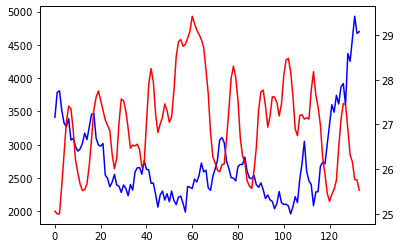

In [7]:
plt.figure()
df.종가.plot(style = 'b-')
df.nino34.plot(secondary_y = True, style = 'r')

## Cross-Correlation

In [5]:
def cross_corr(x, y, lag):
    return x.corr(y.shift(periods=lag))

In [6]:
cc = [cross_corr(df['nino34'], df['종가'], lag=i) for i in range(13)]
cc

[-0.5160620328289677,
 -0.4787420187571255,
 -0.42810203598664215,
 -0.37779219556015226,
 -0.3319495422811955,
 -0.3242463216328173,
 -0.3486498175278745,
 -0.4088786906448838,
 -0.47505933996253524,
 -0.5200528800247579,
 -0.537773756865121,
 -0.5052713174917699,
 -0.4387044949441734]

## 예측 데이터셋 생성
### 종속/독립 변수의 이전 값(t-n) 열 추가
snippet from: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
values = df[['종가', 'nino34']].values
data = series_to_supervised(values, n_in = 2)

In [3]:
df['nino-1'] = df['nino34'].shift(periods = 1)
df['nino-2'] = df['nino34'].shift(periods = 2)
df['종가-1'] = df['종가'].shift(periods = 1)
df['종가-2'] = df['종가'].shift(periods = 2)

In [4]:
data = df.drop(columns = ['nino34'])

In [5]:
data.dropna(inplace = True)

In [6]:
data.set_index('DATE', inplace = True)

In [7]:
data

,종가,nino-1,nino-2,종가-1,종가-2
DATE,,,,,
2011-01-01,3809.0,25.00,25.06,3788.0,3412.0
2011-02-01,3515.0,25.00,25.00,3809.0,3788.0
2011-03-01,3326.0,25.64,25.00,3515.0,3809.0
2011-04-01,3270.0,26.36,25.64,3326.0,3515.0
2011-05-01,3393.0,27.05,26.36,3270.0,3326.0
...,...,...,...,...,...
2021-08-01,4254.0,26.90,27.45,4369.0,3599.0
2021-09-01,4595.0,26.32,26.90,4254.0,4369.0
2021-10-01,4929.0,26.16,26.32,4595.0,4254.0


### 변수간 상관 확인
price vs price[-1]

Autocorrelation at lag = 1:	 0.9518766509128006


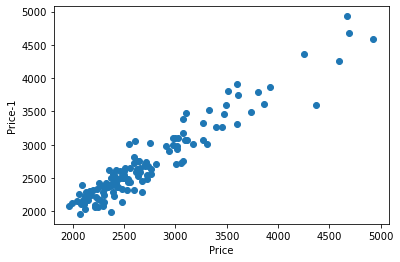

In [34]:
plt.scatter(data['종가'], data['종가-1'])
plt.xlabel('Price')
plt.ylabel('Price-1')

s = pd.Series(data['종가'])
print('Autocorrelation at lag = 1:\t', s.autocorr(lag=1))

nino[-1] vs nino[-2]

Autocorrelation at lag = 1:	 0.9165253657739503


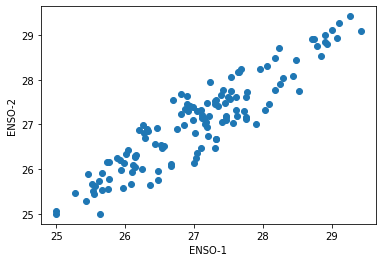

In [35]:
plt.scatter(data['nino-1'], data['nino-2'])
plt.xlabel('ENSO-1')
plt.ylabel('ENSO-2')

s = pd.Series(data['nino-1'])
print('Autocorrelation at lag = 1:\t', s.autocorr(lag=1))  

x = 엘니뇨-1

y = price 수익률(= price/price[-1] - 1)

In [36]:
X_del_nino = data['nino-1']
# Y_yield = (data['종가']/data['종가-1'])-1
Y_yield = data['종가'] - data['종가-1']

Text(0, 0.5, 'Yield')

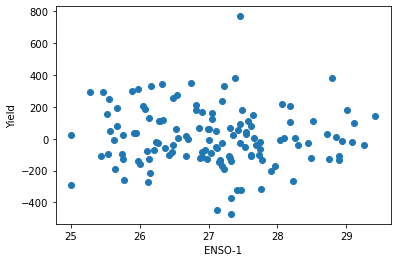

In [37]:
plt.scatter(X_del_nino, Y_yield)
plt.xlabel('ENSO-1')
plt.ylabel('Yield')

x = 엘니뇨변화(= nino[-1] - nino[-2])

y = price 수익률(= price/price[-1] - 1)

In [51]:
X_del_nino = data['nino-1'] - data['nino-2']
# Y_yield = (data['종가']/data['종가-1'])-1
Y_yield = data['종가'] - data['종가-1']

Text(0, 0.5, 'Yield')

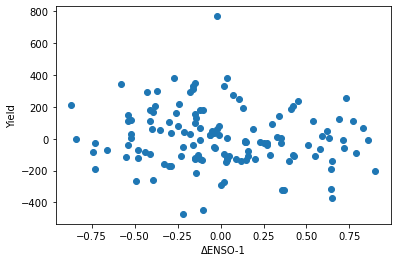

In [52]:
plt.scatter(X_del_nino, Y_yield)
plt.xlabel('\u0394ENSO-1')
plt.ylabel('Yield')

## Residual
x = 엘니뇨-1

y = residual price (seasonality 제거한 price)


code snippet from: https://coderzcolumn.com/tutorials/data-science/how-to-remove-trend-and-seasonality-from-time-series-data-using-python-pandas

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

<ipython-input-11-437374e58f5f>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decompose_result = seasonal_decompose(data['종가'], model="additive", freq=12, extrapolate_trend=2)
C:\Users\limsoo31\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\limsoo31\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\limsoo31\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\limsoo31\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)


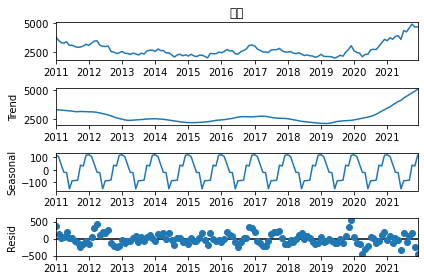

In [11]:
decompose_result = seasonal_decompose(data['종가'], model="additive", freq=12, extrapolate_trend=2)

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

In [12]:
data['종가resd'] = residual

<AxesSubplot:xlabel='DATE'>

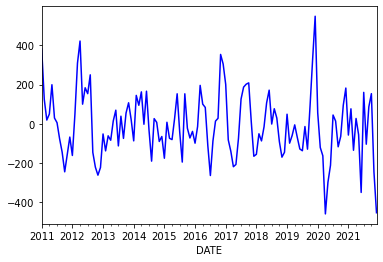

In [13]:
plt.figure()
data.종가resd.plot(style = 'b-')

In [14]:
X_del_nino = data['nino-1']
Y_yield = residual

Text(0, 0.5, 'Price Residual')

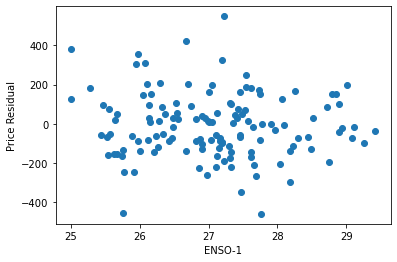

In [15]:
plt.scatter(X_del_nino, Y_yield)
plt.xlabel('ENSO-1')
plt.ylabel('Price Residual')

### train set 만들기
과적합 방지를 위하여 전체 중 60%만 학습에 사용한다. 모델마다 들어가는 독립변수가 다르므로 split 코드는 모델마다 새로 실행한다.

In [17]:
predict_var = '종가'

In [18]:
y = data[predict_var]

In [27]:
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

## Multiple Linear Regression
### ENSO-2, ENSO-1, Price-1

In [29]:
x = data.drop(columns = [predict_var, '종가-2'])

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
LR = LinearRegression()
LR.fit(x_train, y_train)

LinearRegression()

In [37]:
y_pred = LR.predict(x)

### 정확도

In [35]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [46]:
print('r2 score: ', r2_score(y, y_pred))
print('mean sqrt error: ', mean_squared_error(y, y_pred))
print('root mean sqrt error: ', np.sqrt(mean_squared_error(y, y_pred)))
print('R2: ', LR.score(x_train, y_train))

r2 score:  0.9094298100108278
mean sqrt error:  33035.55992908348
root mean sqrt error:  181.75687037656508
R2:  0.9261376125123769


### 가시화

Text(0, 0.5, 'Predicted Price')

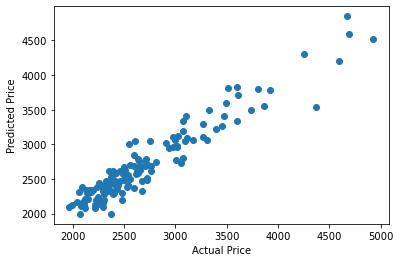

In [40]:
plt.scatter(y, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

### 중요성
code snippet from: https://hleecaster.com/ml-multiple-linear-regression-example/

In [41]:
LR.coef_

array([-62.66411051,  33.73545954,   0.93668832])

Text(0, 0.5, 'Price')

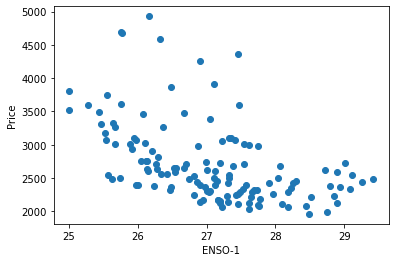

In [43]:
plt.scatter(x['nino-1'], y)
plt.xlabel('ENSO-1')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

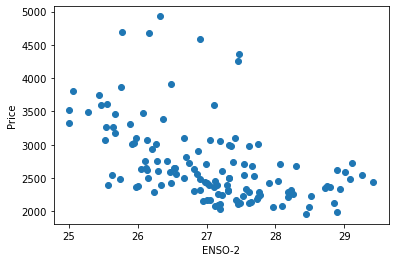

In [44]:
plt.scatter(x['nino-2'], y)
plt.xlabel('ENSO-2')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

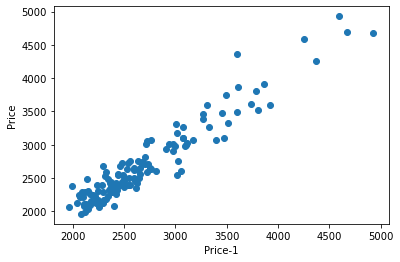

In [45]:
plt.scatter(x['종가-1'], y)
plt.xlabel('Price-1')
plt.ylabel('Price')

## Random Forest Regression 1
### ENSO-2, ENSO-1, Price-1
데이터셋이 충분히 크지 않아 x_train 대신 x를 이용하여 y를 예측한다.

In [ ]:
x = data.drop(columns = [predict_var])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)

RandomForestRegressor()

In [28]:
y_pred = regressor.predict(x)

### 정확도

In [29]:
errors = abs(y_pred - y)
print('Mean Absolute Error ', round(np.mean(errors), 2))

Mean Absolute Error  99.06


In [30]:
mape = 100 * (errors / y)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%')

Accuracy:  96.38 %


In [ ]:
r2_score(y_test, y_pred)

### 중요성
snippet from: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [32]:
feature_list = list(x.columns)
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: 종가-1                 Importance: 0.87
Variable: 종가-2                 Importance: 0.08
Variable: nino-1               Importance: 0.02
Variable: nino-2               Importance: 0.02


### 가시화
snippet from: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [33]:
result_df = pd.concat([pd.DataFrame(y), pd.DataFrame(y_pred, index=y.index.copy())], axis = 1)

In [34]:
result_df.rename(columns = {0: 'predict'}, inplace = True)

In [35]:
result_df.head()

,종가,predict
DATE,,
2011-01-01,3809.0,3734.03
2011-02-01,3515.0,3628.30
2011-03-01,3326.0,3570.11
2011-04-01,3270.0,3560.40
2011-05-01,3393.0,3414.98


<AxesSubplot:label='1a273551-389a-4d68-b42f-b2b4c986c7db'>

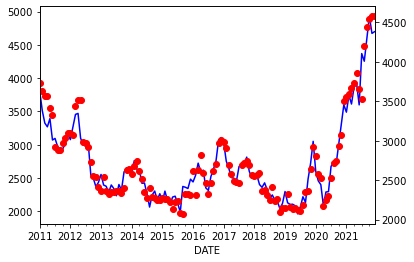

In [36]:
plt.figure()
result_df.종가.plot(style = 'b-')
result_df.predict.plot(secondary_y = True, style = 'ro')

## Random Forest Regression 2
### ENSO-2, ENSO-1

In [37]:
data = df.drop(columns = ['nino34', '평균가', '등락률(%)', '환산가($/ton)', '종가-1', '종가-2'])
data.dropna(inplace = True)

In [38]:
data.head()

,종가,nino-1,nino-2
DATE,,,
2011-01-01,3809.0,25.00,25.06
2011-02-01,3515.0,25.00,25.00
2011-03-01,3326.0,25.64,25.00
2011-04-01,3270.0,26.36,25.64
2011-05-01,3393.0,27.05,26.36


In [39]:
y = data[predict_var]
x = data.drop(columns = [predict_var])

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x)

In [41]:
errors = abs(y_pred - y)
print('Mean Absolute Error ', round(np.mean(errors), 2))

mape = 100 * (errors / y)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%')

# r2_score(y_test, y_pred)

Mean Absolute Error  276.38
Accuracy:  89.92 %


In [42]:
feature_list = list(x.columns)
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: nino-1               Importance: 0.55
Variable: nino-2               Importance: 0.45


In [43]:
regressor.score(x, y)

0.47123267204015407

In [44]:
result_df = pd.concat([pd.DataFrame(y), pd.DataFrame(y_pred, index=y.index.copy())], axis = 1)

In [45]:
result_df.rename(columns = {0: 'predict'}, inplace = True)

<AxesSubplot:label='919eeb99-48b0-4356-976a-32dfabd372f5'>

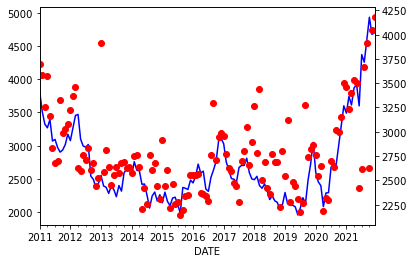

In [46]:
plt.figure()
result_df.종가.plot(style = 'b-')
result_df.predict.plot(secondary_y = True, style = 'ro')

## Random Forest Regression with TimeSeriesSplit
code snippet from: https://www.kaggle.com/tomwarrens/timeseriessplit-how-to-use-it

and https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

In [14]:
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
import warnings
warnings.filterwarnings('ignore')

In [15]:
n_splits = 10
tscv = TimeSeriesSplit(n_splits = n_splits)

In [19]:
X = data['nino-1']
y = data['종가resd']

In [57]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

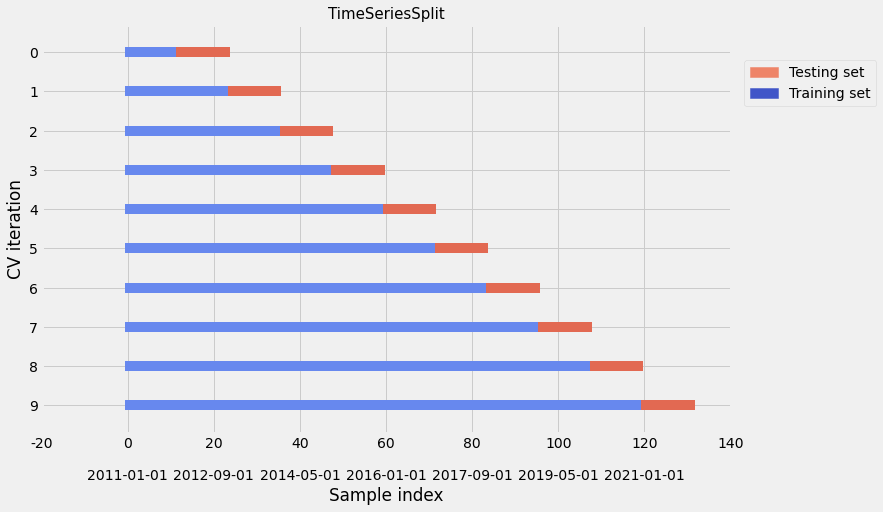

In [62]:
plot_cv_indices(tscv,n_splits, X, y, date_col = data.index.to_series())

In [63]:
from sklearn.ensemble import RandomForestRegressor

-0.41539032322230285
-4.002616439582637
-0.861204058640926
-0.9959364886736946
-0.8938700407190863
-0.2990399122626206
-2.2791175340457297
-0.5717722608912901
-0.32741723397655265
0.1897744465095511


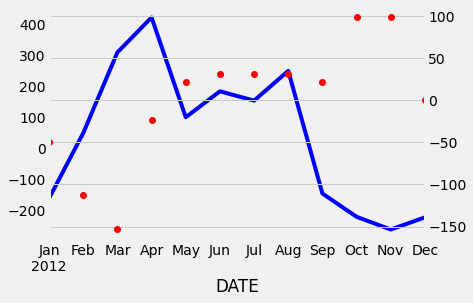

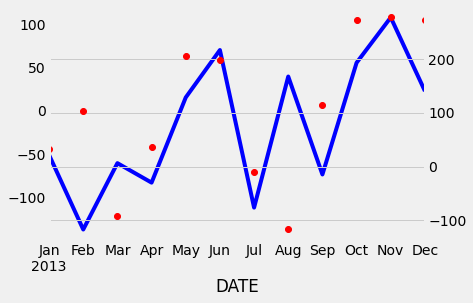

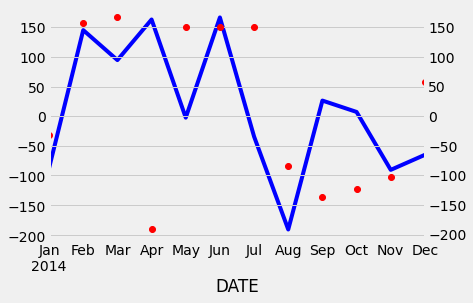

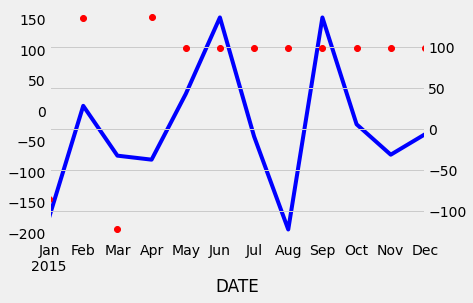

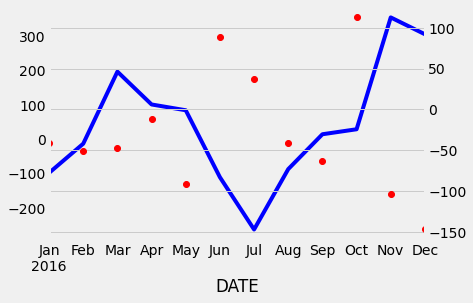

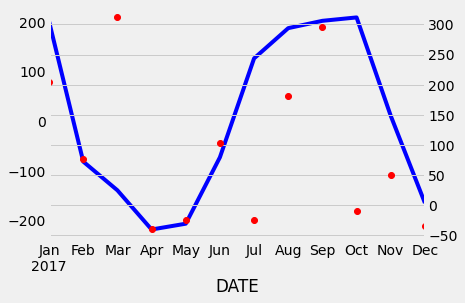

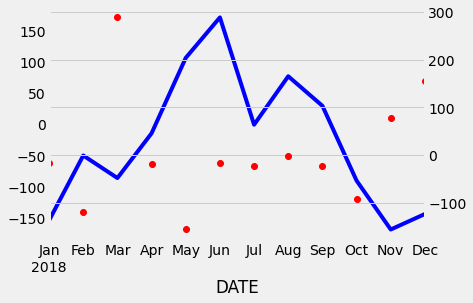

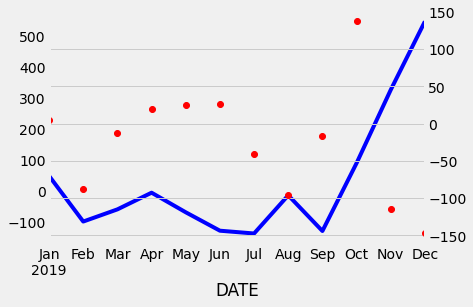

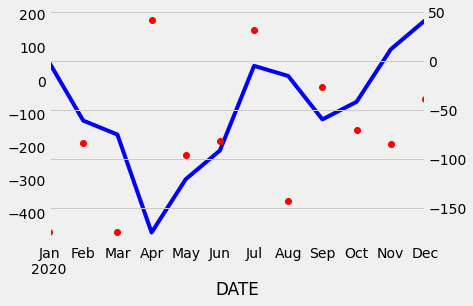

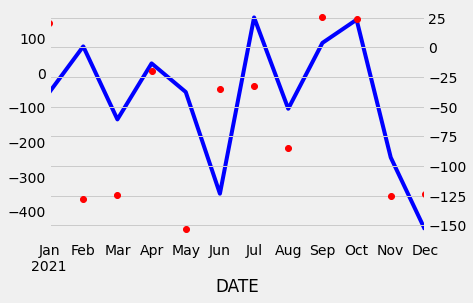

In [64]:
for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    regressor = RandomForestRegressor()
    regressor.fit(np.array(X_train.tolist()).reshape(-1, 1), y_train)
    
    y_pred = regressor.predict(np.array(X_test.tolist()).reshape(-1, 1))
    
    print(regressor.score(np.array(X_test.tolist()).reshape(-1, 1), y_test))
#     print('r2 score: ', r2_score(y_test, y_pred))
    
    result_df = pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_pred, index=y_test.index.copy())], axis = 1)
    result_df.rename(columns = {0: 'predict'}, inplace = True)
    
    plt.figure()
    result_df.종가resd.plot(style = 'b-')
    result_df.predict.plot(secondary_y = True, style = 'ro')

# SARIMAX
code snippet from: https://hongl.tistory.com/99

and: https://sosoeasy.tistory.com/397

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX

## split by date
code snippet from: https://dsbook.tistory.com/274

In [9]:
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')

In [16]:
y = data['종가']

In [10]:
X_train, X_test, y_train, y_test = datasplit_ts(data, '종가', 'nino-1', '2018-01-01')

Train_size: (84, 5) Test_size: (48, 5)
X_train: (84,) Y_train: (84,)
X_test: (48,) Y_test: (48,)


In [20]:
import itertools

## Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

## Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
S = 12 # seasonal
seasonal_pdq = [(x[0], x[1], x[2], S) for x in list(itertools.product(p, d, q))]

In [24]:
import warnings
warnings.filterwarnings(action='ignore')

In [25]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = SARIMAX(y_train, exog=None, order = param,
                            seasonal_order = param_seasonal,
                            enforce_stationarity=True,
                            enforce_invertibility=True)
            
            res = tmp_mdl.fit()        
            print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, res.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1566.0090317493452
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1490.9278155423135
SARIMAX(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1441.9762612513675
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1078.9674677030894
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1070.128355561132
SARIMAX(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1063.993720365231
SARIMAX(0, 0, 0)x(0, 2, 0, 12)12 - AIC:956.1728105198106
SARIMAX(0, 0, 0)x(0, 2, 1, 12)12 - AIC:927.899240904803
SARIMAX(0, 0, 0)x(0, 2, 2, 12)12 - AIC:929.8941808793287
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1306.3384093287636
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1305.6356196333722
SARIMAX(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1302.007440382461
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1074.497422056801
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1064.6815504350607
SARIMAX(0, 0, 0)x(1, 1, 2, 12)12 - AIC:1065.2291444719554
SARIMAX(0, 0, 0)x(1, 2, 0, 12)12 - AIC:939.1129567011905
SARIMAX(0, 0, 0)x(1, 2, 1, 12)12 - AIC:929.8947089917773
SARIMAX(0, 0, 0)x(1, 2, 

SARIMAX(0, 1, 2)x(1, 1, 1, 12)12 - AIC:953.3192371409978
SARIMAX(0, 1, 2)x(1, 1, 2, 12)12 - AIC:955.3427565446281
SARIMAX(0, 1, 2)x(1, 2, 0, 12)12 - AIC:846.6059949871018
SARIMAX(0, 1, 2)x(1, 2, 1, 12)12 - AIC:835.8396783501887
SARIMAX(0, 1, 2)x(1, 2, 2, 12)12 - AIC:837.6213784142292
SARIMAX(0, 1, 2)x(2, 0, 0, 12)12 - AIC:1082.6889817332776
SARIMAX(0, 1, 2)x(2, 0, 1, 12)12 - AIC:1083.9397418676594
SARIMAX(0, 1, 2)x(2, 0, 2, 12)12 - AIC:1085.4067277826223
SARIMAX(0, 1, 2)x(2, 1, 0, 12)12 - AIC:958.8285153711724
SARIMAX(0, 1, 2)x(2, 1, 1, 12)12 - AIC:955.1964868376739
SARIMAX(0, 1, 2)x(2, 1, 2, 12)12 - AIC:957.3209832374725
SARIMAX(0, 1, 2)x(2, 2, 0, 12)12 - AIC:841.1039315087556
SARIMAX(0, 1, 2)x(2, 2, 1, 12)12 - AIC:837.7058291057728
SARIMAX(0, 1, 2)x(2, 2, 2, 12)12 - AIC:839.8428336165576
SARIMAX(0, 2, 0)x(0, 0, 0, 12)12 - AIC:1118.44267027251
SARIMAX(0, 2, 0)x(0, 0, 1, 12)12 - AIC:1120.4148454983886
SARIMAX(0, 2, 0)x(0, 0, 2, 12)12 - AIC:1136.3947559585245
SARIMAX(0, 2, 0)x(0, 1, 0, 

SARIMAX(1, 0, 1)x(2, 1, 1, 12)12 - AIC:981.9521055632642
SARIMAX(1, 0, 1)x(2, 1, 2, 12)12 - AIC:984.3192922621988
SARIMAX(1, 0, 1)x(2, 2, 0, 12)12 - AIC:871.5504717929375
SARIMAX(1, 0, 1)x(2, 2, 1, 12)12 - AIC:869.638594039237
SARIMAX(1, 0, 1)x(2, 2, 2, 12)12 - AIC:871.847626690648
SARIMAX(1, 0, 2)x(0, 0, 0, 12)12 - AIC:1099.9759788057913
SARIMAX(1, 0, 2)x(0, 0, 1, 12)12 - AIC:1101.658206487265
SARIMAX(1, 0, 2)x(0, 0, 2, 12)12 - AIC:1103.3865361071037
SARIMAX(1, 0, 2)x(0, 1, 0, 12)12 - AIC:1006.3089981137048
SARIMAX(1, 0, 2)x(0, 1, 1, 12)12 - AIC:981.0836637211293
SARIMAX(1, 0, 2)x(0, 1, 2, 12)12 - AIC:982.0007032768774
SARIMAX(1, 0, 2)x(0, 2, 0, 12)12 - AIC:895.1417440019369
SARIMAX(1, 0, 2)x(0, 2, 1, 12)12 - AIC:868.1676818791897
SARIMAX(1, 0, 2)x(0, 2, 2, 12)12 - AIC:868.7518055063118
SARIMAX(1, 0, 2)x(1, 0, 0, 12)12 - AIC:1101.6849161996329
SARIMAX(1, 0, 2)x(1, 0, 1, 12)12 - AIC:1102.9129168808352
SARIMAX(1, 0, 2)x(1, 0, 2, 12)12 - AIC:1105.634643088196
SARIMAX(1, 0, 2)x(1, 1, 0, 1

SARIMAX(1, 2, 1)x(0, 1, 1, 12)12 - AIC:941.0018035981562
SARIMAX(1, 2, 1)x(0, 1, 2, 12)12 - AIC:942.9507219274437
SARIMAX(1, 2, 1)x(0, 2, 0, 12)12 - AIC:861.0830009411443
SARIMAX(1, 2, 1)x(0, 2, 1, 12)12 - AIC:828.8773105027582
SARIMAX(1, 2, 1)x(0, 2, 2, 12)12 - AIC:822.9456079525631
SARIMAX(1, 2, 1)x(1, 0, 0, 12)12 - AIC:1070.737549192792
SARIMAX(1, 2, 1)x(1, 0, 1, 12)12 - AIC:1072.2069806645022
SARIMAX(1, 2, 1)x(1, 0, 2, 12)12 - AIC:1074.257635653611
SARIMAX(1, 2, 1)x(1, 1, 0, 12)12 - AIC:949.3579500871889
SARIMAX(1, 2, 1)x(1, 1, 1, 12)12 - AIC:942.9479140831645
SARIMAX(1, 2, 1)x(1, 1, 2, 12)12 - AIC:945.006191993459
SARIMAX(1, 2, 1)x(1, 2, 0, 12)12 - AIC:833.9147567361125
SARIMAX(1, 2, 1)x(1, 2, 1, 12)12 - AIC:823.1079802647394
SARIMAX(1, 2, 1)x(1, 2, 2, 12)12 - AIC:824.9503562090686
SARIMAX(1, 2, 1)x(2, 0, 0, 12)12 - AIC:1072.7193489900833
SARIMAX(1, 2, 1)x(2, 0, 1, 12)12 - AIC:1074.2577043084314
SARIMAX(1, 2, 1)x(2, 0, 2, 12)12 - AIC:1075.5521651468582
SARIMAX(1, 2, 1)x(2, 1, 0, 1

SARIMAX(2, 1, 0)x(1, 1, 1, 12)12 - AIC:953.3335711284293
SARIMAX(2, 1, 0)x(1, 1, 2, 12)12 - AIC:955.3477328391392
SARIMAX(2, 1, 0)x(1, 2, 0, 12)12 - AIC:846.4687983464561
SARIMAX(2, 1, 0)x(1, 2, 1, 12)12 - AIC:835.8456384312842
SARIMAX(2, 1, 0)x(1, 2, 2, 12)12 - AIC:837.6638828692733
SARIMAX(2, 1, 0)x(2, 0, 0, 12)12 - AIC:1082.6776512204965
SARIMAX(2, 1, 0)x(2, 0, 1, 12)12 - AIC:1083.9353088712705
SARIMAX(2, 1, 0)x(2, 0, 2, 12)12 - AIC:1085.405841656149
SARIMAX(2, 1, 0)x(2, 1, 0, 12)12 - AIC:958.8704402595782
SARIMAX(2, 1, 0)x(2, 1, 1, 12)12 - AIC:955.2052018830817
SARIMAX(2, 1, 0)x(2, 1, 2, 12)12 - AIC:957.3284971430047
SARIMAX(2, 1, 0)x(2, 2, 0, 12)12 - AIC:841.0570910508197
SARIMAX(2, 1, 0)x(2, 2, 1, 12)12 - AIC:837.7333609880834
SARIMAX(2, 1, 0)x(2, 2, 2, 12)12 - AIC:839.8470663931547
SARIMAX(2, 1, 1)x(0, 0, 0, 12)12 - AIC:1080.9538771931723
SARIMAX(2, 1, 1)x(0, 0, 1, 12)12 - AIC:1082.5744918943385
SARIMAX(2, 1, 1)x(0, 0, 2, 12)12 - AIC:1084.387370826841
SARIMAX(2, 1, 1)x(0, 1, 0, 

SARIMAX(2, 2, 2)x(2, 1, 2, 12)12 - AIC:949.2955301819463
SARIMAX(2, 2, 2)x(2, 2, 0, 12)12 - AIC:833.344971211833
SARIMAX(2, 2, 2)x(2, 2, 1, 12)12 - AIC:829.0610657040328
SARIMAX(2, 2, 2)x(2, 2, 2, 12)12 - AIC:840.5318870937259
Best SARIMAX(0, 0, 0)x(2, 0, 1, 12)12 model - AIC:8.0


In [32]:
# Best SARIMAX(0, 0, 0)x(2, 0, 1, 12)12 model - AIC:8.0
## Define SARIMAX model and fit it to the data
mdl = SARIMAX(endog=y_train, order=(2, 1, 0),
            seasonal_order=(2, 1, 0, 12),
            enforce_stationarity=True,
            enforce_invertibility=True)
res = mdl.fit()

In [33]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 종가   No. Observations:                   84
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -474.435
Date:                            Wed, 30 Mar 2022   AIC                            958.870
Time:                                    00:55:20   BIC                            970.184
Sample:                                01-01-2011   HQIC                           963.369
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1582      0.148     -1.068      0.285      -0.449       0.132
ar.L2         -0.0894      0.151     -0.592      0.554      -0.386       0.207
ar.S.L12      -0.7039      0.127     -5.532      0.000      -0.953      -0.455
ar.S.L24      -0.2237      0.114     -1.967      0.049      -0.447      -0.001
sigma2      3.482e+04   6390.406      5.449      0.000    2.23e+04    4.73e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.85   Prob(JB):                         0.85
Heteroskedasticity (H):               1.04   Skew:                             0.14
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\limsoo31\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\limsoo31\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)


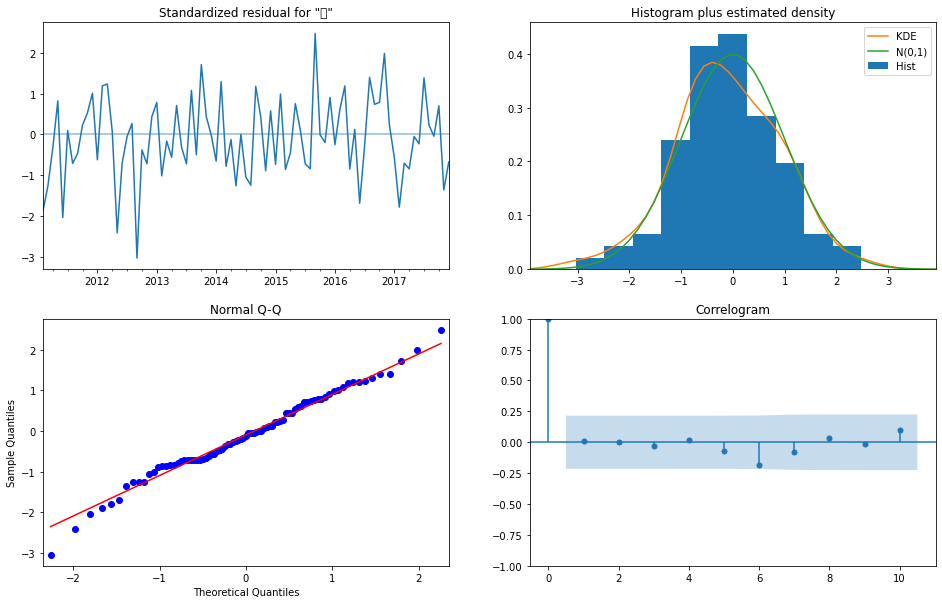

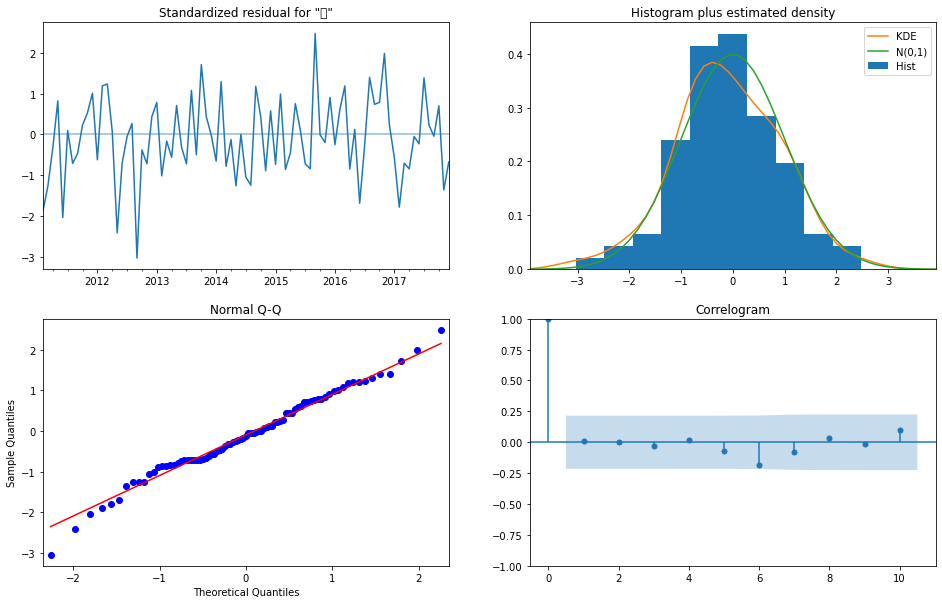

In [20]:
res.plot_diagnostics(figsize=(16, 10))

In [35]:
## In-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('2018-01-01'), 
                        end=pd.to_datetime('2021-12-01'),
                        dynamic=True,
                        exog=X_test)

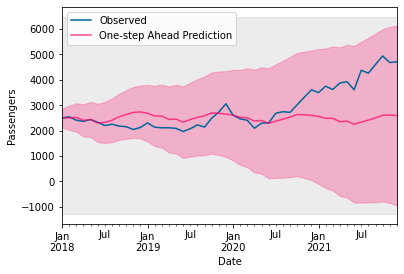

In [36]:
pred_ci = pred.conf_int()

## Plot in-sample-prediction
ax = y['2018':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');

## Draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);

## style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');
plt.legend(loc='upper left');
plt.show()

In [11]:
mdl = SARIMAX(endog=y_train, order=(2, 1, 0),
            seasonal_order=(0, 0, 0, 12),
            enforce_stationarity=True,
            enforce_invertibility=True)
res = mdl.fit()

C:\Users\limsoo31\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\limsoo31\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [12]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     종가   No. Observations:                   84
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -536.535
Date:                Thu, 31 Mar 2022   AIC                           1079.070
Time:                        00:27:50   BIC                           1086.326
Sample:                    01-01-2011   HQIC                          1081.985
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0167      0.153     -0.109      0.913      -0.316       0.282
ar.L2          0.0309      0.138      0.224      0.823      -0.239       0.301
sigma2      2.411e+04   3635.009      6.634      0.000     1.7e+04    3.12e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.95   Prob(JB):                         0.78
Heteroskedasticity (H):               0.85   Skew:                            -0.14
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\limsoo31\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\limsoo31\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)


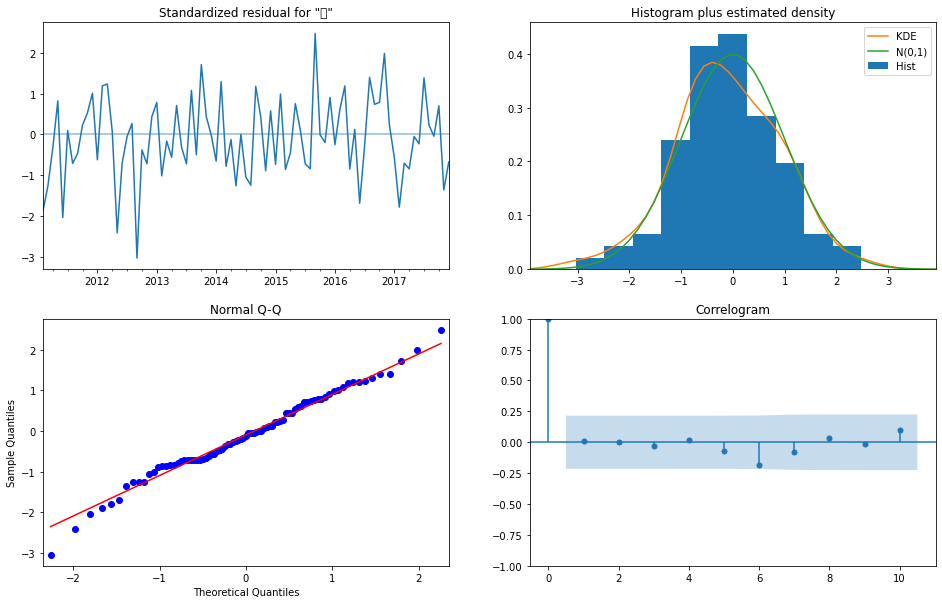

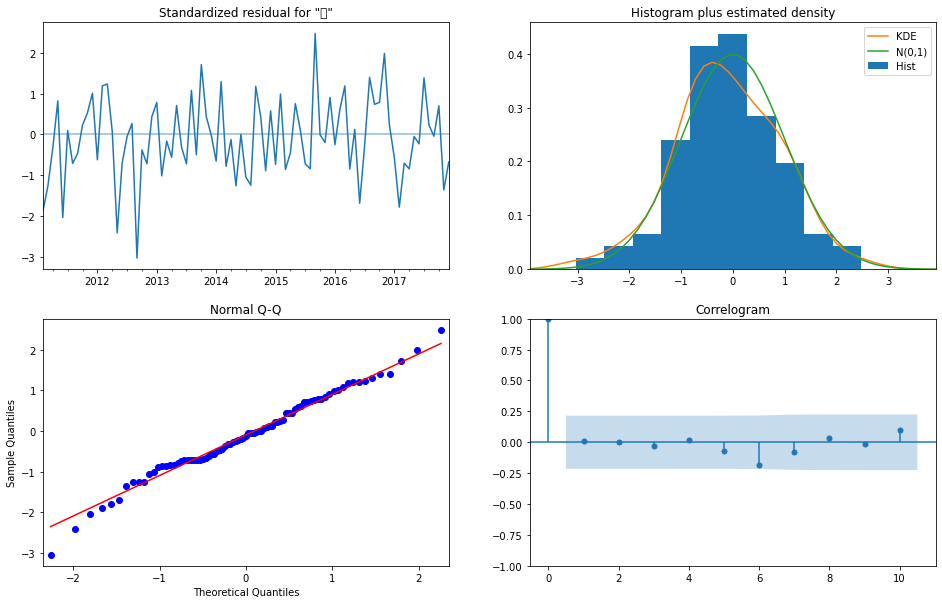

In [13]:
res.plot_diagnostics(figsize=(16, 10))

In [14]:
pred = res.get_prediction(start=pd.to_datetime('2018-01-01'), 
                        end=pd.to_datetime('2021-12-01'),
                        dynamic=True,
                        exog=X_test)

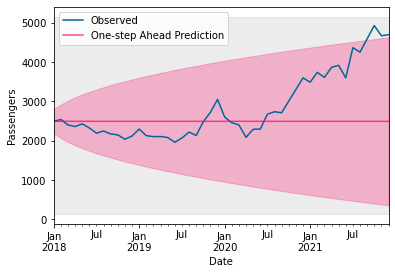

In [19]:
pred_ci = pred.conf_int()

## Plot in-sample-prediction
ax = y['2018':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');

## Draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);

## style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');
plt.legend(loc='upper left');
plt.show()